# Projet 9 : Prédisez une demande en électricité

- Corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire.
- Effectuez une désaisonnalisation de la consommation que vous aurez obtenue après correction, grâce aux moyennes mobiles.
- Effectuez une prévision de la consommation (corrigée de l'effet température) sur un an, en utilisant la méthode de Holt Winters (lissage exponentiel) puis la méthode SARIMA sur la série temporelle.

# Importation des données et définition des fonctions de nettoyage

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
import datetime 
from sklearn import decomposition
from sklearn import preprocessing
#from functions import *
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import KMeans
from scipy.stats import norm
import warnings
import itertools
import statsmodels.api as sm
import pmdarima as pm

In [3]:
# fonction clé primaire
def test_primary_key(df, column):
        if len(df) == len(df[column].drop_duplicates()):
                print("la clé  est unique")
        else : print('la clé n est pas unique')
        print('___')

#obsolète. A mettre de côté puis supprimer
def test_valeurs_manquantes(df):
    print(df.isin(['NaN']).any())

#fonction is_null
def test_is_null(df):
    print('Test de chaque variable avec isnull')
    print(df.isnull().sum())
    print('___')

#fonction affichage médiane
def func_affichage_mediane(df, column, unite):
    print('la valeur mediane est de {}'.format(df[column].median()), unite)

#fonction affichage moyenne
def func_affichage_moyenne(df, column, unite):
    print('la valeur moyenne est de {}'.format(df[column].mean()), unite)

#Au préalable on crée une fonction pour connaître notre nombre de ligne supprimées
def pourcentage_supprimé(df, df_supprimé):
    print('Le pourcentage de lignes supprimées est de: {:.4f}'.format(len(df_supprimé)/len(df)*100), '%.',\
          '{}'.format(len(df_supprimé)), 'lignes ont été supprimées' ) 
    print('sur {}'.format(len(df_supprimé)+len(df)))


def short_function_analyse_univariée(df,column):
    print('la valeur mediane de {} est de {}'.format(column, df[column].median()))
    print('la valeur moyenne de {} est de {}'.format(column, df[column].mean()))
    print('___')

# Traitement des données


In [4]:
nouvelles_donnees = pd.read_csv('data_conso.csv')
nouvelles_donnees

,date,consommation,prevision_j1,prevision_j,fioul,charbon,gaz,nucleaire,eolien,solaire,hydraulique,pompage,bioenergies
0,2012-01-01,2471592.0,4901850.0,4841050.0,23649.0,758.0,181778.0,2153346.0,188459.0,6255.0,367472.0,-86821.0,33411.0
1,2012-01-02,2912815.0,5796450.0,5739050.0,23598.0,378.0,194404.0,2557111.0,147353.0,4267.0,412364.0,-50571.0,31219.0
2,2012-01-03,3252581.0,6349550.0,6392550.0,24700.0,205.0,193376.0,2794380.0,228569.0,6768.0,484559.0,-48850.0,31888.0
3,2012-01-04,3265403.0,6455450.0,6430900.0,26208.0,7.0,178234.0,2767347.0,203392.0,8655.0,490193.0,-42190.0,32737.0
4,2012-01-05,3319555.0,6410150.0,6484500.0,25809.0,16.0,203859.0,2712466.0,249564.0,3207.0,516675.0,-40085.0,32991.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283,2020-12-27,2990748.0,5842450.0,5976350.0,4460.0,404.0,116636.0,2125269.0,519656.0,12306.0,298783.0,-82738.0,53499.0
3284,2020-12-28,3101704.0,6460350.0,6156450.0,4495.0,421.0,186115.0,2268938.0,368355.0,19619.0,433347.0,-39110.0,52210.0
3285,2020-12-29,3138620.0,6264900.0,6239650.0,4494.0,426.0,236159.0,2370694.0,207355.0,23846.0,387266.0,-21963.0,52231.0
3286,2020-12-30,3176874.0,6332550.0,6338750.0,4490.0,387.0,231034.0,2383663.0,165890.0,27771.0,339525.0,-33099.0,52108.0


In [5]:
nouvelles_donnees_2 = nouvelles_donnees.copy()
nouvelles_donnees_2 = nouvelles_donnees_2[['date', 'consommation']]
nouvelles_donnees_2

,date,consommation
0,2012-01-01,2471592.0
1,2012-01-02,2912815.0
2,2012-01-03,3252581.0
3,2012-01-04,3265403.0
4,2012-01-05,3319555.0
...,...,...
3283,2020-12-27,2990748.0
3284,2020-12-28,3101704.0
3285,2020-12-29,3138620.0
3286,2020-12-30,3176874.0


On a ici des données journalières et non mensuelles. On veut les transformer en données mensuelles.

In [6]:
#on veut group by nos dates par mois. Pour cela on enlève d'abord les jours.
nouvelles_donnees_2['date'] = nouvelles_donnees_2['date'].str[:-3]
nouvelles_donnees_2 = nouvelles_donnees_2.groupby(['date']).mean().reset_index()

#nos valeurs sont en 10exposant6. On les ramène à des int
nouvelles_donnees_2['consommation'] = nouvelles_donnees_2['consommation'].astype('int64')

#pour pouvoir avoir le même format que nos données de chauffage plus bas, on met tout en datetime
nouvelles_donnees_2['date'] = pd.to_datetime(nouvelles_donnees_2['date'], format='%Y-%m')
nouvelles_donnees_2

,date,consommation
0,2012-01-01,3276550
1,2012-02-01,3736692
2,2012-03-01,2770679
3,2012-04-01,2663312
4,2012-05-01,2260569
...,...,...
103,2020-08-01,2012199
104,2020-09-01,2140765
105,2020-10-01,2458247
106,2020-11-01,2642383


<AxesSubplot:xlabel='date'>

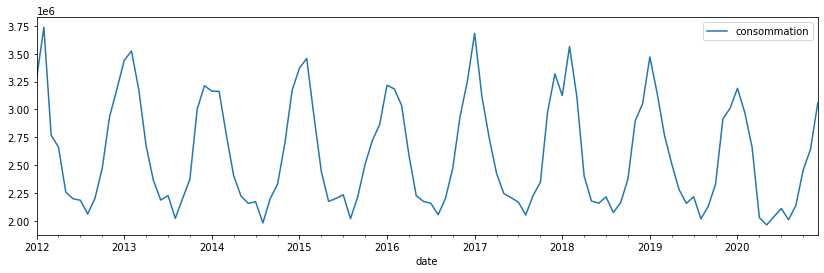

In [7]:
nouvelles_donnees_2.plot(x= 'date', y="consommation", figsize=(14,4))

In [8]:
#chauffage par mois - Toulouse - 01/01/2012 au 31/12/2020 - Température de référence : 18°C
df_meteo = pd.read_csv('DJU_Mensuel.csv', header=None)
df_meteo.rename(columns={0 : 'Annee'}, inplace=True)
df_meteo.drop(columns={13}, inplace=True)
df_meteo.drop([0], axis=0, inplace=True)
df_meteo

,Annee,1,2,3,4,5,6,7,8,9,10,11,12
1,2020.0,"308,7","222,8","227,1","79,7","27,4","13,4",0,0,"28,1","134,9","174,7","322,8"
2,2019.0,"406,8",244,"217,7","159,9","95,8","22,3",0,0,"6,3","53,3",253,"264,6"
3,2018.0,"275,7","363,1","261,2","112,1","76,1","1,9",0,0,"2,9","103,7","210,7",282
4,2017.0,"436,6","238,5","202,3","143,4","47,5","5,8","1,3","2,2","30,7","64,3","284,3","361,8"
5,2016.0,"288,2",277,"259,3","151,6",77,"9,5","1,6",0,"4,5","92,9","216,2","334,8"
6,2015.0,"375,2","349,1","227,8","111,1","42,9",1,"1,3","0,3","23,7","109,7","187,5","234,5"
7,2014.0,"290,3","271,7","227,2","109,7","82,1","1,9","0,9","0,8","6,7","38,7","146,6",363
8,2013.0,"391,8","353,2","250,7","182,4","143,5","28,1",0,0,"12,9",55,"281,4","347,1"
9,2012.0,"348,6","472,7","207,3","184,1","57,4","6,3","3,4","0,1","16,6","85,1",229,"311,3"


In [9]:
df_meteo_melted = pd.melt(df_meteo, id_vars=['Annee'], var_name='mois', value_name='chauffage')
df_meteo_melted = df_meteo_melted.sort_values(by=['Annee','mois'])
df_meteo_melted

,Annee,mois,chauffage
8,2012.0,1,"348,6"
17,2012.0,2,"472,7"
26,2012.0,3,"207,3"
35,2012.0,4,"184,1"
44,2012.0,5,"57,4"
...,...,...,...
63,2020.0,8,0
72,2020.0,9,"28,1"
81,2020.0,10,"134,9"
90,2020.0,11,"174,7"


In [10]:
#on fusionne nos colonnes Annee et Mois
df_meteo_melted['Annee'] = df_meteo_melted['Annee'].astype(str)
df_meteo_melted['Annee'] = df_meteo_melted['Annee'].str[:-2]
df_meteo_melted['mois'] = df_meteo_melted['mois'].astype(str)
df_meteo_melted['Annee'] = df_meteo_melted['Annee'] + '-' + df_meteo_melted['mois']
df_meteo_melted.drop(columns=['mois'], inplace=True)

#on remet note colonne Annee en dataetime, comme notre df conso plus haut.
df_meteo_melted['Annee'] = pd.to_datetime(df_meteo_melted['Annee'], format='%Y-%m')
df_meteo_melted.rename(columns={'Annee':'date'}, inplace=True)
df_meteo_melted

,date,chauffage
8,2012-01-01,"348,6"
17,2012-02-01,"472,7"
26,2012-03-01,"207,3"
35,2012-04-01,"184,1"
44,2012-05-01,"57,4"
...,...,...
63,2020-08-01,0
72,2020-09-01,"28,1"
81,2020-10-01,"134,9"
90,2020-11-01,"174,7"


In [11]:
df_conso_chauffage = pd.merge(nouvelles_donnees_2, df_meteo_melted)
df_conso_chauffage

,date,consommation,chauffage
0,2012-01-01,3276550,"348,6"
1,2012-02-01,3736692,"472,7"
2,2012-03-01,2770679,"207,3"
3,2012-04-01,2663312,"184,1"
4,2012-05-01,2260569,"57,4"
...,...,...,...
103,2020-08-01,2012199,0
104,2020-09-01,2140765,"28,1"
105,2020-10-01,2458247,"134,9"
106,2020-11-01,2642383,"174,7"


In [12]:
#on doit mettre la date en index sinon la regression lineaire ne peut pas fonctionner
df_conso_chauffage = df_conso_chauffage.set_index('date')
df_conso_chauffage['chauffage'] = df_conso_chauffage['chauffage'].str.replace(',','.')
df_conso_chauffage['chauffage'] = df_conso_chauffage['chauffage'].astype(float)
df_conso_chauffage

,consommation,chauffage
date,,
2012-01-01,3276550,348.6
2012-02-01,3736692,472.7
2012-03-01,2770679,207.3
2012-04-01,2663312,184.1
2012-05-01,2260569,57.4
...,...,...
2020-08-01,2012199,0.0
2020-09-01,2140765,28.1
2020-10-01,2458247,134.9


In [13]:
df_conso_chauffage.dtypes

consommation      int64
chauffage       float64
dtype: object

# Corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire.

## Regression linéaire - Initial Setup

In [14]:
#https://www.youtube.com/watch?v=P6kSc3qVph0

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
y= df_conso_chauffage['consommation']
X=df_conso_chauffage.drop('consommation', axis=1)

In [17]:
model = LinearRegression()
model.fit(X,y)

LinearRegression()

In [18]:
model.coef_[0]

3496.9921227300224

In [19]:
model.score(X,y)
#notre coeff de détermination est 95 (notre R²). On prédit donc 95% des resultats.

0.9529166400427076

## Hypothèses régression linéaire

<AxesSubplot:xlabel='consommation', ylabel='chauffage'>

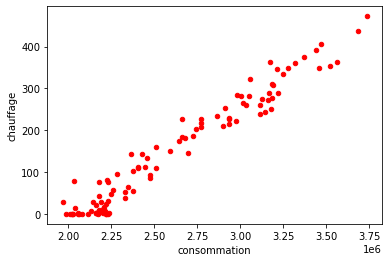

In [20]:
#On part du principe qu'on a pas d'outliers
df_conso_chauffage.plot.scatter(x='consommation',y='chauffage', c='r')

In [21]:
#https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/

#Linéarité
#problème possible : The predictions will be extremely inaccurate because our model is underfitting. 
#This is a serious violation that should not be ignored.

## Régression linéaire et calcul de la consommation corrigée

La régression linéaire est une technique statistique de modélisation des relations entre différentes variables (dépendantes et indépendantes). Utilisée pour décrire et analyser les valeurs ou données, la régression linéaire a pour objectif de réaliser des prédictions ou des prévisions. Elle a recours à la méthode d’estimation par les moindres carrés ordinaires (MCO) qui établissent une équation linéaire en réduisant la somme des valeurs résiduelles mises au carré.

Le but est d'identifier les variables explicatives qui sont associées à la variable dépendante, pour ensuite faire des prévisions.

In [22]:
model.predict(X)

array([3310472.69865198, 3744449.42108277, 2816347.71171023,
       2735217.49446289, 2292148.592513  , 2113452.29504149,
       2103311.01788557, 2091770.94388057, 2149471.31390561,
       2389015.27431262, 2892232.44077347, 3180034.89247415,
       3461542.75835392, 3326558.86241654, 2968117.16983671,
       2729272.60785425, 2593239.61428005, 2189686.72331701,
       2091421.24466829, 2091421.24466829, 2136532.44305151,
       2283755.81141844, 3075474.82800452, 3305227.21046788,
       3106598.05789682, 3041554.00441404, 2885937.85495255,
       2475041.28053178, 2378524.29794443, 2098065.52970148,
       2094568.53757875, 2094218.83836648, 2114851.09189058,
       2226754.83981794, 2604080.28986051, 3360829.38521929,
       3403492.6891166 , 3312221.19471334, 2888036.05022619,
       2479937.0695036 , 2241442.20673341, 2094918.23679102,
       2095967.33442784, 2092470.34230511, 2174299.95797699,
       2475041.28053178, 2747107.26768017, 2911465.89744848,
       3099254.37443908,

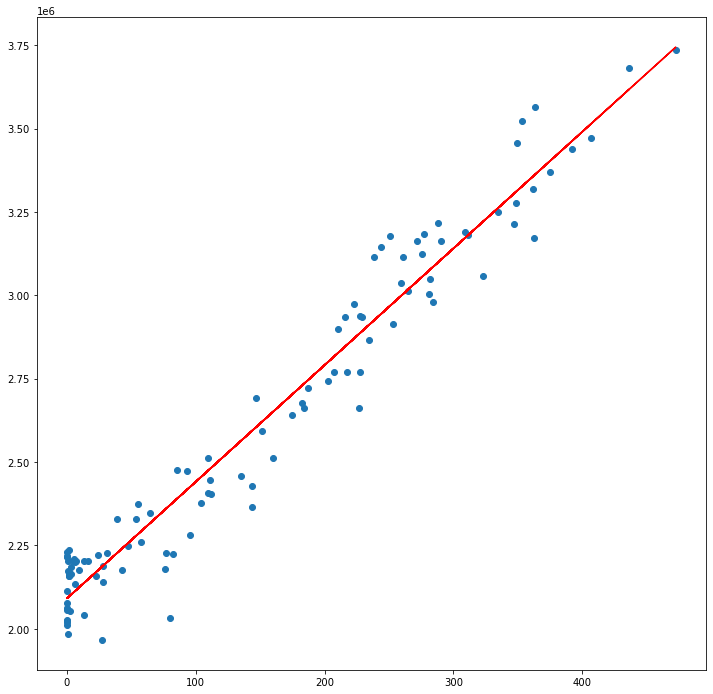

In [23]:
predictions = model.predict(X)
plt.figure(figsize =(12, 12))
plt.scatter(X,y)
plt.plot(X, predictions, c='r')
plt.savefig('linear_regression.jpg')
plt.show()

In [24]:
#ax+b
print('{} x + {}'.format(model.coef_, model.intercept_) )

[3496.99212273] x + 2091421.2446682923


In [25]:
coeff = model.coef_[0]
coeff

3496.9921227300224

In [26]:
df_conso_chauffage['consommation_predict'] = df_conso_chauffage['consommation'] - df_conso_chauffage['chauffage']*coeff
df_conso_chauffage

,consommation,chauffage,consommation_predict
date,,,
2012-01-01,3276550,348.6,2.057499e+06
2012-02-01,3736692,472.7,2.083664e+06
2012-03-01,2770679,207.3,2.045753e+06
2012-04-01,2663312,184.1,2.019516e+06
2012-05-01,2260569,57.4,2.059842e+06
...,...,...,...
2020-08-01,2012199,0.0,2.012199e+06
2020-09-01,2140765,28.1,2.042500e+06
2020-10-01,2458247,134.9,1.986503e+06


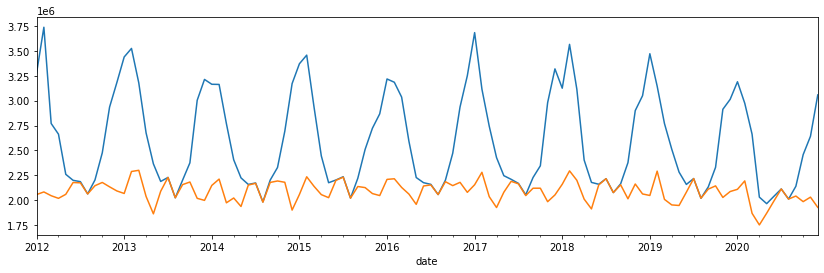

In [27]:
df_conso_chauffage['consommation'].plot(y='consommation', figsize=(14,4))
df_conso_chauffage['consommation_predict'].plot(y='consommation_predict', figsize=(14,4))
plt.savefig('conso_prediction.jpg')

## Hypothèse de linéarité

Cela suppose qu'il existe une relation linéaire entre les prédicteurs (par exemple, variables indépendantes ou caractéristiques) et la variable de réponse (par exemple, variable dépendante ou étiquette). Cela suppose également que les prédicteurs sont additifs.

La régression linéaire ne serait pas un estimateur approprié s'il n'y avait pas de relation linéaire. On pourrait alors avoir de l'underfitting.

In [28]:
def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=7)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()

In [29]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


C:\Users\jb-14\anaconda3\lib\site-packages\seaborn\regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


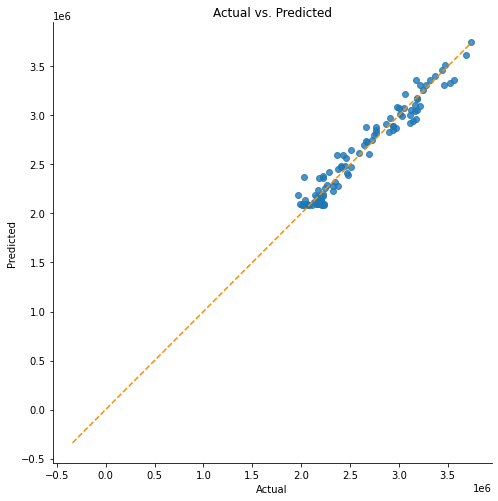

In [30]:
linear_assumption(model, X, y)

## Hypothèse de distribution normale

L'hypothèse ici est que les termes d'erreur du modèle sont normalement distribués. Si on avait fait une régression autre que celle des moindres carrés ordinaires, on devait également supposer la normalité des prédicteurs ou de l'étiquette, mais ce n'est pas le cas ici.

In [31]:
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.20676413294545354
Residuals are normally distributed


C:\Users\jb-14\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


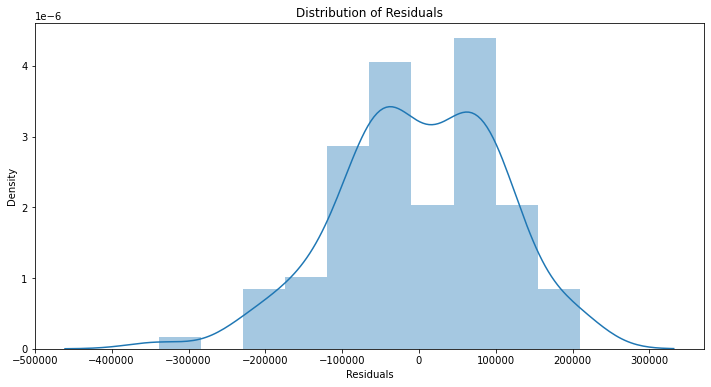


Assumption satisfied


In [32]:
normal_errors_assumption(model, X, y)

## Hypothèse de non-multicolinéarité

Beaucoup de données sont naturellement corrélées. La multicolinéarité pose des problèmes d'interprétation des coefficients. Plus précisément, on peut interpréter un coefficient comme une augmentation de 1 dans ce prédicteur entraîne une modification de (coefficient) dans la variable de réponse, en maintenant tous les autres prédicteurs constants. Cela devient problématique lorsque la multicolinéarité est présente car nous ne pouvons pas maintenir constants les prédicteurs corrélés. De plus, cela augmente l'erreur type des coefficients, ce qui fait qu'ils apparaissent potentiellement comme statistiquement non significatifs alors qu'ils pourraient en fait être significatifs.

Afin de détecter la multicolinéarité, nous utiliserons une carte thermique de la corrélation comme aide visuelle et examinerons le facteur d'inflation de la variance (VIF) (VIF: rapport (quotient) de la variance de l'estimation d'un paramètre dans un modèle qui comprend plusieurs autres termes (paramètres) par la variance d'un modèle construit à l'aide d'un seul terme)

Comment résoudre ce problème : on peut supprimer les prédicteurs avec un facteur d'inflation de la variance (VIF) élevé ou en effectuant une dimensionality reduction.

In [33]:
def multicollinearity_assumption(model, features, label, feature_names=None):
    """
    Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                       correlation among the predictors, then either remove prepdictors with high
                       Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                       This assumption being violated causes issues with interpretability of the 
                       coefficients and the standard errors of the coefficients.
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    print('Assumption 3: Little to no multicollinearity among predictors')
        
    # Plotting the heatmap
    plt.figure(figsize = (10,8))
    sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=True)
    plt.title('Correlation of Variables')
    plt.show()
        
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
       
    # Gathering the VIF for each variable
    VIF = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))
        
    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')
            print()
            print('Coefficient interpretability may be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')

In [34]:
#multicollinearity_assumption(model, X, y, linear_feature_names)

## Hypothèse de non autocorrélation

La présence d'une autocorrélation indique généralement qu'il nous manque certaines informations qui devraient être prise en compte par le modèle.

In [35]:
def autocorrelation_assumption(model, features, label):
    """
    Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                     autocorrelation, then there is a pattern that is not explained due to
                     the current value being dependent on the previous value.
                     This may be resolved by adding a lag variable of either the dependent
                     variable or some of the predictors.
    """
    from statsmodels.stats.stattools import durbin_watson
    print('Assumption 4: No Autocorrelation', '\n')
    
    # Calculating residuals for the Durbin Watson-tests
    df_results = calculate_residuals(model, features, label)

    print('\nPerforming Durbin-Watson Test')
    print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('0 to 2< is positive autocorrelation')
    print('>2 to 4 is negative autocorrelation')
    print('-------------------------------------')
    durbinWatson = durbin_watson(df_results['Residuals'])
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')

In [36]:
autocorrelation_assumption(model, X, y)

Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.5318836796175905
Little to no autocorrelation 

Assumption satisfied


## Hypothèse de non Homoscédasticité

Cela peut arriver quand notre modèle accorde trop de poids à un sous-ensemble de données, en particulier là où la variance d'erreur était la plus élevée.

L'hétéroscédasticité peut être résolue soit en utilisant la régression pondérée des moindres carrés au lieu de l'OLS standard (la méthode des moindre carrés oridnaires standards), soit en transformant les variables dépendantes ou fortement asymétriques. Effectuer une transformation de journal sur la variable dépendante n'est pas un mauvais point de départ.

In [37]:
def homoscedasticity_assumption(model, features, label):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show()  

In [38]:
#homoscedasticity_assumption(model, X, y)

Il ne semble pas y avoir de problèmes.

# Effectuez une désaisonnalisation de la consommation que vous aurez obtenue après correction, grâce aux moyennes mobiles.

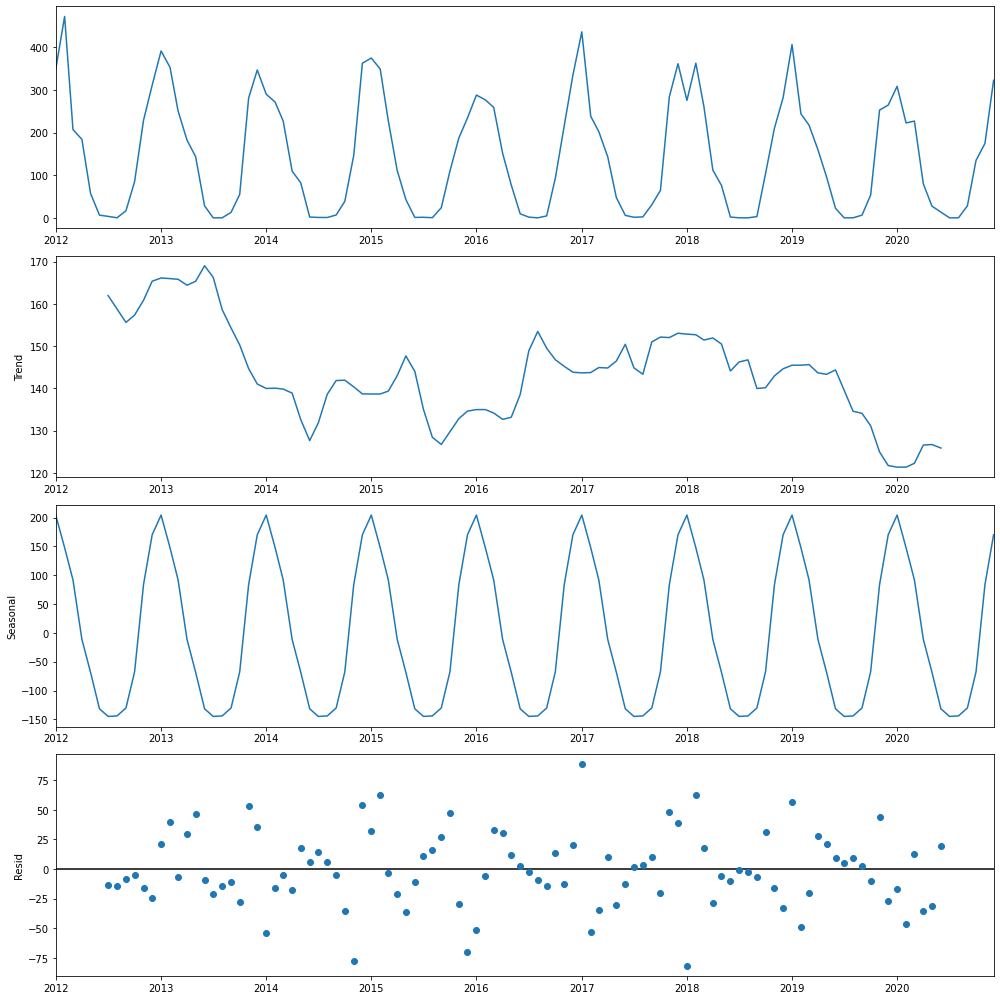

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pylab import rcParams

rcParams['figure.figsize'] = [14,14]

decomp_x = seasonal_decompose(X,  model='additive')
decomp_x.plot()
plt.savefig('desaisonnalisation.jpg')
plt.show()

Dans l'ordre, nos graphique sont notre série, la tendance, la saisonalité, et en dernier les résidus (séries temporelles après l'élimination des composantes de tendance et de saisonnalité).

Comme nous pouvons le constater, les données présentent une tendance à la baisse et une saisonnalité annuelle (décalage de  12).

Une moyenne mobile est un type de moyenne statistique utilisée pour analyser des séries ordonnées de données, notamment des séries temporelles, en supprimant les fluctuations transitoires de façon à en souligner les tendances à plus long terme.

In [40]:
df_conso_chauffage['conso_desaisonnalisee'] = df_conso_chauffage['consommation_predict'] - decomp_x.seasonal.values

In [41]:
df_conso_chauffage

,consommation,chauffage,consommation_predict,conso_desaisonnalisee
date,,,,
2012-01-01,3276550,348.6,2.057499e+06,2.057294e+06
2012-02-01,3736692,472.7,2.083664e+06,2.083516e+06
2012-03-01,2770679,207.3,2.045753e+06,2.045661e+06
2012-04-01,2663312,184.1,2.019516e+06,2.019527e+06
2012-05-01,2260569,57.4,2.059842e+06,2.059910e+06
...,...,...,...,...
2020-08-01,2012199,0.0,2.012199e+06,2.012343e+06
2020-09-01,2140765,28.1,2.042500e+06,2.042630e+06
2020-10-01,2458247,134.9,1.986503e+06,1.986570e+06


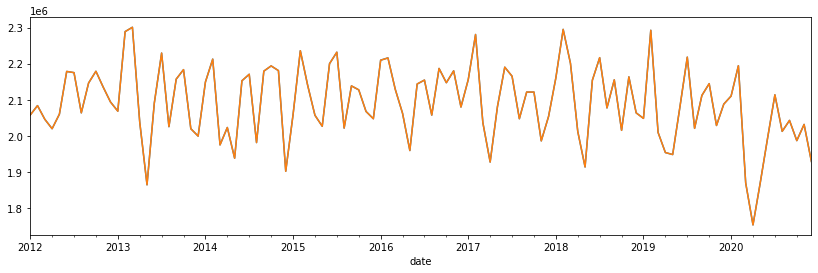

In [42]:
df_conso_chauffage['consommation_predict'].plot(y='consommation_predict', figsize=(14,4))
df_conso_chauffage['conso_desaisonnalisee'].plot(y='conso_desaisonnalisee', figsize=(14,4))

plt.savefig('conso_desaisonnalisee.jpg')

La différence entre les 2 courbes est invisible sur le graphique. Peut-être est-ce dû au fait que j'ai pris les données de Toulouse, ville relativement chaude.

# Effectuez une prévision de la consommation (corrigée de l'effet température) sur un an, en utilisant la méthode de Holt Winters (lissage exponentiel) puis la méthode SARIMA sur la série temporelle.

## Holt-Wintrs

L' objectif de la méthode de Holt-Winters est de prévoir à la date T une série temporelle à un horizon ℓ à partir de T observations. C'est une méthode à lissage exponentiel double.

In [43]:
df_conso_chauffage_until_2020 = df_conso_chauffage.head(96).copy()

C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


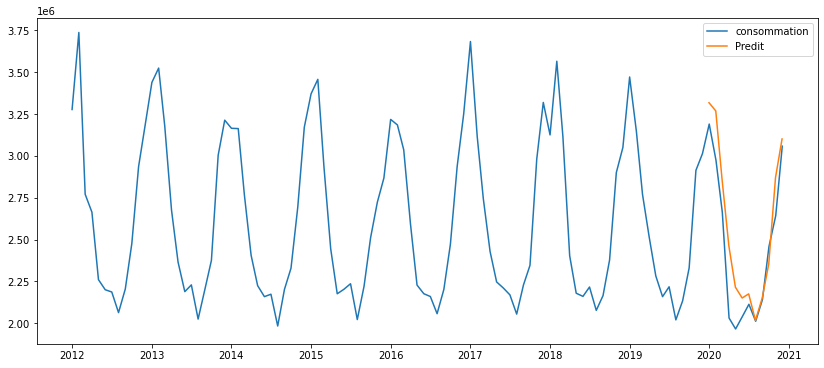

In [44]:
from statsmodels.tsa.api import ExponentialSmoothing
hw = ExponentialSmoothing(np.asarray(df_conso_chauffage_until_2020['consommation']), seasonal_periods=12, trend='mul', seasonal='mul').fit()
hw_pred = hw.forecast(12)

plt.figure(figsize=(14,6))
plt.plot(df_conso_chauffage['consommation'], label='consommation')
plt.plot(pd.date_range(df_conso_chauffage_until_2020.index[len(df_conso_chauffage_until_2020)-1], periods=12, freq='M'), hw_pred, label='Predit')
plt.legend()
plt.savefig('Holt-Wintrs.jpg')

plt.show()

In [60]:
from sklearn.metrics import mean_squared_error
rmse_holt_winters = mean_squared_error(hw_pred, df_conso_chauffage['consommation'].tail(12),squared=False)
print('The Root Mean Squared Error is {}'.format(mean_squared_error(hw_pred, df_conso_chauffage['consommation'].tail(12),squared=False)), 2)

The Root Mean Squared Error is 197921.6379475721 2


## SARIMA

In [46]:
#https://www.wisdomgeek.com/development/machine-learning/sarima-forecast-seasonal-data-using-python/

seasonal ARIMA. Autoregressive integrated moving average. C'est un procesus non stationnaire (processus dont la distribution de probabilité varie de manière non constante). C'est un processus ARIMA auquel on a rajouté une saisonnalité.

AR : autorégressif. Le passé de la série explique la série à l'instant t. Les autocorrélations partielles des processus de type ARp s'annulent à partir du rang p+1, et les autocorrélations simple décroissent rapidement vers 0.

Intégré : Utilisation de la différenciation des observations brutes (par exemple, soustraction d'une observation de l'observation au pas de temps précédent) afin de rendre la série temporelle stationnaire.

MA : Les autocorrélations simples des processus de type MA s'annulent à partir du rang p+1, et les autocorrélations partielles décroissent rapidement vers 0.

In [47]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

from statsmodels.tsa.stattools import acf, pacf
def plot_sortie_acf( y_acf, y_len, pacf=False):
    "représentation de la sortie ACF"
    if pacf:
        y_acf = y_acf[1:]
    plt.figure(figsize=(14,6))
    plt.bar(range(len(y_acf)), y_acf, width = 0.1)
    plt.xlabel('lag')
    plt.ylabel('ACF')
    plt.axhline(y=0, color='black')
    plt.axhline(y=-1.96/np.sqrt(y_len), color='b', linestyle='--', linewidth=0.8)
    plt.axhline(y=1.96/np.sqrt(y_len), color='b', linestyle='--', linewidth=0.8)
    plt.ylim(-1, 1)
    plt.show()
    return

In [48]:
print(adf_test(df_conso_chauffage['consommation']))

Results of Dickey-Fuller Test:
Test Statistic                 -0.435787
p-value                         0.903950
#Lags Used                     12.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64
None


Après avoir exécuté le test ADF sur la série chronologique, nous obtenons le résultat suivant. Comme la valeur p de 0,90 est supérieure à la valeur critique de 0,05, nous pouvons confirmer statistiquement que la série n'est pas stationnaire. Par conséquent, nous ferons un différentiel de premier ordre pour la tendance et nous exécuterons à nouveau le test ADF pour vérifier la stationnarité.


Results of Dickey-Fuller Test:
Test Statistic                -7.813853e+00
p-value                        6.953999e-12
#Lags Used                     1.100000e+01
Number of Observations Used    9.500000e+01
Critical Value (1%)           -3.501137e+00
Critical Value (5%)           -2.892480e+00
Critical Value (10%)          -2.583275e+00
dtype: float64
None


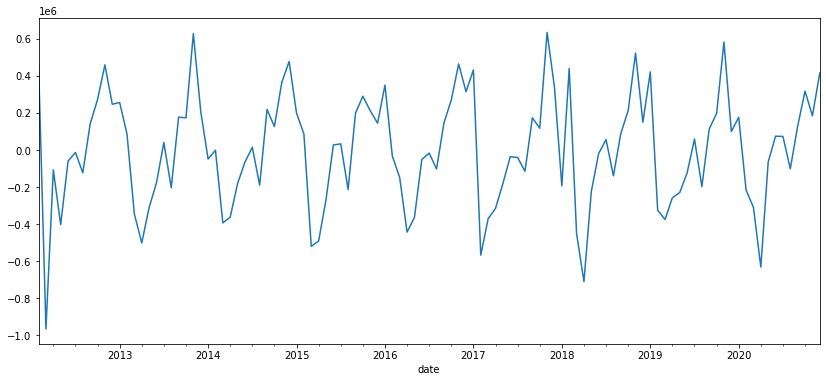

In [49]:
ts_t_adj = df_conso_chauffage['consommation'] - df_conso_chauffage['consommation'].shift(1)
ts_t_adj = ts_t_adj.dropna()

ts_t_adj_until_2020 = df_conso_chauffage_until_2020['consommation'] - df_conso_chauffage_until_2020['consommation'].shift(1)
ts_t_adj_until_2020 = ts_t_adj_until_2020.dropna()

rcParams['figure.figsize'] = [14,6]
ts_t_adj.plot()



#A checker
print(adf_test(ts_t_adj))

La tendance semble maintenant avoir disparu des données. L'exécution du test ADG valide l'observation. La valeur p est inférieure à la valeur critique de 0,05. Nous pouvons donc confirmer que la série est maintenant stationnaire en tendance.

<AxesSubplot:xlabel='date'>

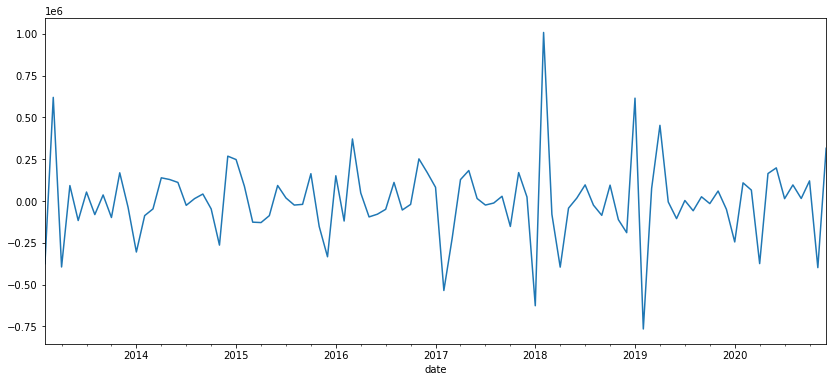

In [50]:
ts_s_adj = ts_t_adj - ts_t_adj.shift(12)
ts_s_adj = ts_s_adj.dropna()

ts_t_adj_until_2020 = ts_t_adj_until_2020 - ts_t_adj_until_2020.shift(12)
ts_t_adj_until_2020 = ts_t_adj_until_2020.dropna()

ts_s_adj.plot()

#Puisque les données montrent une saisonnalité annuelle, nous effectuerons la différenciation saisonnière avec un shift de 12.

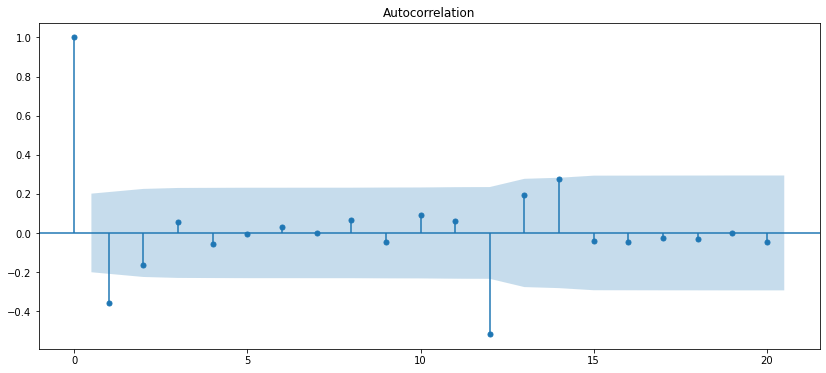

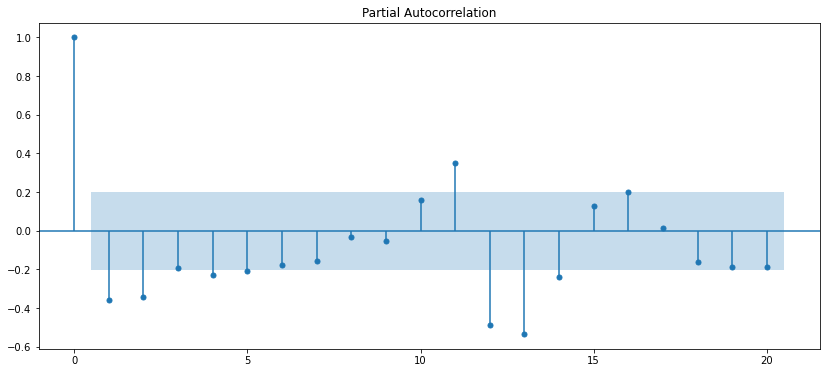

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_s_adj)
plt.show()
plot_pacf(ts_s_adj)
plt.savefig('ACF_PACF.jpg')
plt.show()

Pour le graphique ACF, des pics initiaux à lag = 1 et des pics saisonniers à lag = 12, ce qui signifie un ordre AR probable de 1 et un ordre AR saisonnier de 1.

Pour le graphique PACF, les pics initiaux au lag = 1 et les pics saisonniers au lag = 12, ce qui signifie un ordre MA probable de 1 ou 2 et un ordre MA saisonnier de 1.

Ainsi, notre équation probable du modèle SARIMA peut être -

SARIMA(1,1,1)x(1,1,1)12

## Création du modèle

Since we are unsure of the exact model equation, we will perform a grid search with the list of possible values around our estimated parameters. We will then pick the model with the least AIC.

In [52]:
p = range(0, 3)
d = range(1,2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
seasonal_pdq


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (0, 1, 1) x (0, 1, 2, 12)
SARIMAX: (0, 1, 2) x (1, 1, 0, 12)
SARIMAX: (0, 1, 2) x (1, 1, 1, 12)


[(0, 1, 0, 12),
 (0, 1, 1, 12),
 (0, 1, 2, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12),
 (1, 1, 2, 12),
 (2, 1, 0, 12),
 (2, 1, 1, 12),
 (2, 1, 2, 12)]

In [53]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:2597.1696053105366
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:2233.851121709289
ARIMA(0, 1, 0)x(0, 1, 2, 12)12 - AIC:6179.073996021521
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:2257.5027525941778


C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency informa

ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:2219.6170491012545
ARIMA(0, 1, 0)x(1, 1, 2, 12)12 - AIC:6092.670616940963
ARIMA(0, 1, 0)x(2, 1, 0, 12)12 - AIC:1915.1896548763432
ARIMA(0, 1, 0)x(2, 1, 1, 12)12 - AIC:1909.6821902778615


C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency informa

ARIMA(0, 1, 0)x(2, 1, 2, 12)12 - AIC:6122.824566161621
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:2544.1159121227047
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:2189.1268825443567
ARIMA(0, 1, 1)x(0, 1, 2, 12)12 - AIC:6100.973468608967


C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency informa

ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:2255.6715989664426
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:2183.6790215427563
ARIMA(0, 1, 1)x(1, 1, 2, 12)12 - AIC:6046.4436823307215


C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency informa

ARIMA(0, 1, 1)x(2, 1, 0, 12)12 - AIC:1914.5996292605196
ARIMA(0, 1, 1)x(2, 1, 1, 12)12 - AIC:1915.9514625975958


C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 1)x(2, 1, 2, 12)12 - AIC:6103.341472849091
ARIMA(0, 1, 2)x(0, 1, 0, 12)12 - AIC:2513.5160672153993


C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 2)x(0, 1, 1, 12)12 - AIC:2158.94784716899
ARIMA(0, 1, 2)x(0, 1, 2, 12)12 - AIC:6006.73753885652
ARIMA(0, 1, 2)x(1, 1, 0, 12)12 - AIC:2251.0505675936556


C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency informa

ARIMA(0, 1, 2)x(1, 1, 1, 12)12 - AIC:2152.2342023934298
ARIMA(0, 1, 2)x(1, 1, 2, 12)12 - AIC:5953.027024843168


C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC:1912.5474966079555


C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(0, 1, 2)x(2, 1, 1, 12)12 - AIC:1913.7821443732948
ARIMA(0, 1, 2)x(2, 1, 2, 12)12 - AIC:6009.129195209094
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:2585.1026572427972
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:2225.1284538658633
ARIMA(1, 1, 0)x(0, 1, 2, 12)12 - AIC:6198.658057591266


C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency informa

ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:2223.4657856013
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:2217.994895338006
ARIMA(1, 1, 0)x(1, 1, 2, 12)12 - AIC:6143.30899904826


C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency informa

ARIMA(1, 1, 0)x(2, 1, 0, 12)12 - AIC:1891.2269401919912
ARIMA(1, 1, 0)x(2, 1, 1, 12)12 - AIC:1890.5306668463043


C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 0)x(2, 1, 2, 12)12 - AIC:6201.002409719061
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:2546.046241346897
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:2190.197925035001
ARIMA(1, 1, 1)x(0, 1, 2, 12)12 - AIC:6100.851541802631


C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency informa

ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:2214.5428260177655
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:2184.1637812681697
ARIMA(1, 1, 1)x(1, 1, 2, 12)12 - AIC:6046.321755523647


C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency informa

ARIMA(1, 1, 1)x(2, 1, 0, 12)12 - AIC:1884.4685464748407
ARIMA(1, 1, 1)x(2, 1, 1, 12)12 - AIC:1884.6595869176087
ARIMA(1, 1, 1)x(2, 1, 2, 12)12 - AIC:6103.219546042016
ARIMA(1, 1, 2)x(0, 1, 0, 12)12 - AIC:2512.011571333274


C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency informa

ARIMA(1, 1, 2)x(0, 1, 1, 12)12 - AIC:2158.982566909386
ARIMA(1, 1, 2)x(0, 1, 2, 12)12 - AIC:6007.613155390249


C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 2)x(1, 1, 0, 12)12 - AIC:2212.661815790757


C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 2)x(1, 1, 1, 12)12 - AIC:2153.0145123006264
ARIMA(1, 1, 2)x(1, 1, 2, 12)12 - AIC:5953.902641376808


C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 2)x(2, 1, 0, 12)12 - AIC:1882.233603184823


C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(1, 1, 2)x(2, 1, 1, 12)12 - AIC:1881.879232445274
ARIMA(1, 1, 2)x(2, 1, 2, 12)12 - AIC:6010.004811742736
ARIMA(2, 1, 0)x(0, 1, 0, 12)12 - AIC:2544.4870265871946
ARIMA(2, 1, 0)x(0, 1, 1, 12)12 - AIC:2218.17626526024


C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency informa

ARIMA(2, 1, 0)x(0, 1, 2, 12)12 - AIC:6189.249493909642
ARIMA(2, 1, 0)x(1, 1, 0, 12)12 - AIC:2188.7414242920736
ARIMA(2, 1, 0)x(1, 1, 1, 12)12 - AIC:2182.806054020856


C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency informa

ARIMA(2, 1, 0)x(1, 1, 2, 12)12 - AIC:6133.900435366388
ARIMA(2, 1, 0)x(2, 1, 0, 12)12 - AIC:1854.8503438000046
ARIMA(2, 1, 0)x(2, 1, 1, 12)12 - AIC:1854.8111988638452
ARIMA(2, 1, 0)x(2, 1, 2, 12)12 - AIC:6103.342505379525
ARIMA(2, 1, 1)x(0, 1, 0, 12)12 - AIC:2546.066154468315


C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency informa

ARIMA(2, 1, 1)x(0, 1, 1, 12)12 - AIC:2190.469263606556
ARIMA(2, 1, 1)x(0, 1, 2, 12)12 - AIC:6101.070842042004
ARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:2187.9302370817086


C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency informa

ARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:2183.3898426731403
ARIMA(2, 1, 1)x(1, 1, 2, 12)12 - AIC:6046.541055763677


C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 1)x(2, 1, 0, 12)12 - AIC:1855.1460923334475


C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 1)x(2, 1, 1, 12)12 - AIC:1854.3962071779167
ARIMA(2, 1, 1)x(2, 1, 2, 12)12 - AIC:6103.438846282044
ARIMA(2, 1, 2)x(0, 1, 0, 12)12 - AIC:2513.933699737276


C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency informa

ARIMA(2, 1, 2)x(0, 1, 1, 12)12 - AIC:2160.3522897965054
ARIMA(2, 1, 2)x(0, 1, 2, 12)12 - AIC:6009.105694788721


C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 2)x(1, 1, 0, 12)12 - AIC:2185.2599511245253


C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 2)x(1, 1, 1, 12)12 - AIC:2154.235480417197
ARIMA(2, 1, 2)x(1, 1, 2, 12)12 - AIC:5955.395180775373


C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 2)x(2, 1, 0, 12)12 - AIC:1853.7146282826793


C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA(2, 1, 2)x(2, 1, 1, 12)12 - AIC:1852.8823657472758
ARIMA(2, 1, 2)x(2, 1, 2, 12)12 - AIC:6011.497351141302


C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


On choisi l'AIC (Akaike Information Criteria) le plus faible. Le modèle sera – ARIMA(2, 1, 2)x(2, 1, 1, 12)12 - AIC:1852.8823657472767.

In [54]:
#ARIMA(2, 1, 2)x(2, 1, 1, 12)12

mod = sm.tsa.statespace.SARIMAX(ts_t_adj_until_2020,
                                order=(2, 1, 2), #paramètres p (AR terms, lags de la série stationnaire),
                                                #d la différenciation entre séries stationnaires
                                                #Q : indique le nombre de termes MA (retards des erreurs de prévision)
                                seasonal_order=(2, 1, 1, 12)) #12 : longeur de la série saisonnière
results = mod.fit(method = 'powell')
print(results.summary())

C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Optimization terminated successfully.
         Current function value: 11.444486
         Iterations: 9
         Function evaluations: 988
                                      SARIMAX Results                                       
Dep. Variable:                         consommation   No. Observations:                   83
Model:             SARIMAX(2, 1, 2)x(2, 1, [1], 12)   Log Likelihood                -949.892
Date:                              Fri, 04 Nov 2022   AIC                           1915.785
Time:                                      18:46:20   BIC                           1933.773
Sample:                                  02-01-2013   HQIC                          1922.930
                                       - 12-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

C:\Users\jb-14\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


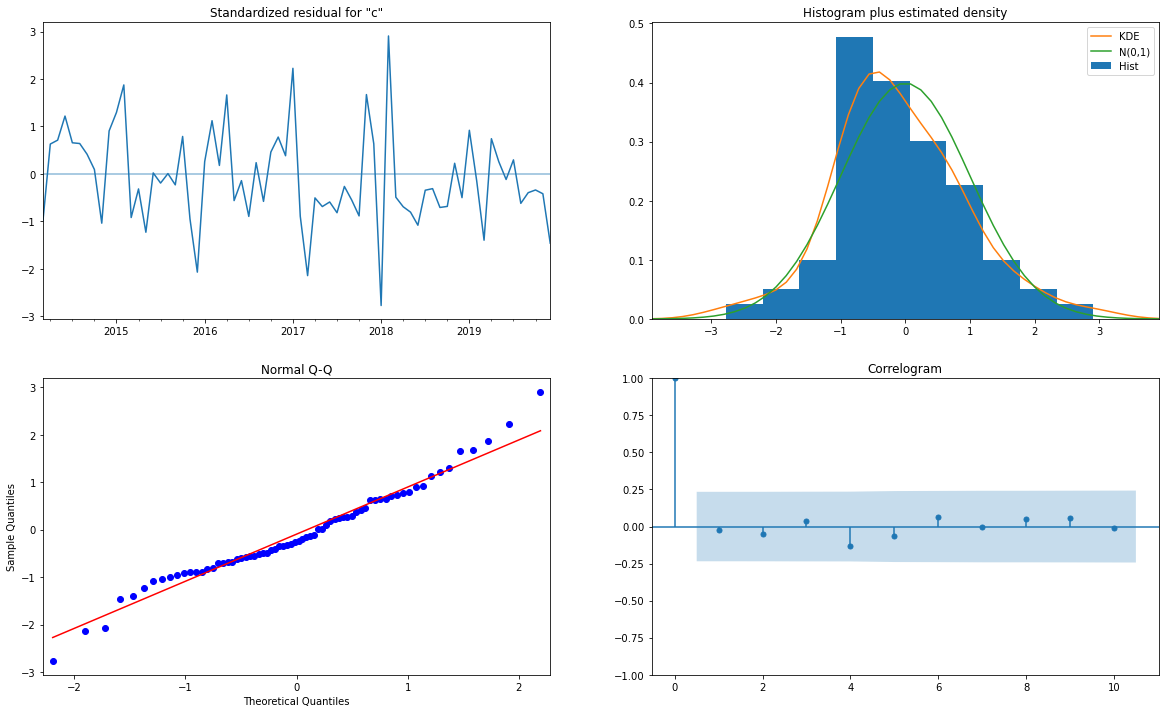

In [55]:
results.plot_diagnostics(figsize=(20, 12))
plt.savefig('diag_SARIMA.jpg')
plt.show()

Distribution des individus suivant une loi qui semble normale.

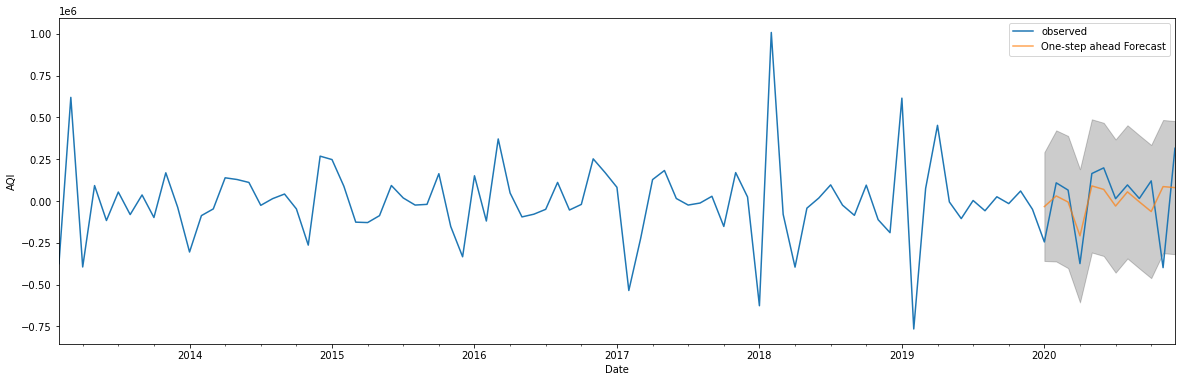

In [56]:
pred = results.get_forecast(12)
pred_ci = pred.conf_int()
ax = ts_s_adj.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(20, 6))
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.2) #couleur de la bande
ax.set_xlabel('Date')
ax.set_ylabel('AQI')
plt.legend()
plt.savefig('SARIMA_predict.jpg')
plt.show()

In [57]:
y_forecasted = pred.predicted_mean
y_truth = ts_s_adj['2019-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 36111386279.12
The Root Mean Squared Error is 190029.96


In [58]:
import statistics
x = np.var(y_truth.values)
statistics.sqrt(x)

270444.773741935

On peut dire que la variance est égale à la RMSE d'un modèle qui prédit systématiquement la moyenne, autrement dit un modèle naïf.
Avec ça, on peut conclure qu'un modèle qui a une RMSE inférieur à la racine carré variance (l'écart type) de l'échantillon est donc un modèle "relativement bon".
En lien une explication détaillée :
https://stats.stackexchange.com/a/375674

La RMSE  mesure l'écart entre une valeur réelle et la prédiction du modèle pour cette valeur. Un bon modèle devrait, en moyenne, avoir de meilleures prédictions que l'estimation naïve de la moyenne pour toutes les prédictions. Ainsi, la mesure de la variation (RMSE) devrait réduire le caractère aléatoire mieux que la déviation standard (SD). Ici 144505.79 < 216768.1440529002 donc on est bon.

### Comparaison des RMSE des 2 modèles

In [62]:
rmse_sarima = round(np.sqrt(mse), 2)

In [71]:
print('La RMSE du modèle SARIMA {} est plus faible que la RMSE du modèle Holt-Winters {:.2f}, on peut donc en conclure que le modèle SARIMA est plus précis'.format(rmse_sarima, rmse_holt_winters,2))

La RMSE du modèle SARIMA 190029.96 est plus faible que la RMSE du modèle Holt-Winters 197921.64, on peut donc en conclure que le modèle SARIMA est plus précis


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1ee07386-aa80-48b6-a794-cb2a65040702' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>